 # Hyperparameter Search for MPF Boosted Model



 In this cell we define helper functions for evaluating one hyperparameter candidate and performing a randomized search in parallel. We then use our random search function on training data.

In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import numpy as np
import mpf_py
from utils import gen_data, true_model3, plot_2d_model_predictions  # Adjust import according to your project structure


 ### Example Usage for MPF



 Here we generate training data (using a hypothetical `gen_data` and `true_model3` from your utils) and run the random hyperparameter search.

In [3]:
# Generate data
x, y = gen_data(n=10000, seed=3, model=true_model3)
x_train = x[:5000]
y_train = y[:5000]

x_test = x[5000:]
y_test = y[5000:]


In [6]:
# Fit the best MPF model
from utils import random_hyperparam_search_parallel
from scipy.stats import randint

best_model, best_fr, best_params, best_error = random_hyperparam_search_parallel(
    x_train, y_train, n_splits=2, n_candidates=50, n_jobs=3, param_distributions= {
        "epochs": lambda: randint(2, 9).rvs(),       # 1 to 8 inclusive
        "n_iter": lambda: randint(5, 101).rvs(),         # 5 to 100 inclusive
        "split_try": lambda: randint(5, 21).rvs(),         # 5 to 20 inclusive
        "n_trees": lambda: randint(10, 101).rvs(),         # 10 to 100 inclusive
        "colsample_bytree": lambda: 1.0,
        "identified": lambda: False
    })
print("Best hyperparameters for MPF:", best_params)
print("Best CV MSE for MPF:", best_error)


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


{'epochs': 6, 'n_iter': 10, 'split_try': 19, 'n_trees': 20, 'colsample_bytree': 1.0, 'identified': False}
{'epochs': 2, 'n_iter': 97, 'split_try': 16, 'n_trees': 28, 'colsample_bytree': 1.0, 'identified': False}
{'epochs': 5, 'n_iter': 63, 'split_try': 7, 'n_trees': 39, 'colsample_bytree': 1.0, 'identified': False}
err: 0.5798691751095344
err: 0.6019480398143305
err: 0.5937006410634543
err: 0.5812495812483272
err: 0.5851225020580768
err: 0.5904401619633598
err: 0.578673273398045
err: 0.5975540955903762
err: 0.6008134202748957
err: 0.613625234702333
err: 0.587394235086985
err: 0.5860951023075048
err: 0.6064441305333005
err: 0.6047299985390922
err: 0.5960454512165295
err: 0.598553318088155
err: 0.5955483231797688
err: 0.50002755065824
err: 0.5916005339727378
err: 0.5871247897035529
err: 0.5043180044894919
err: 0.4989297693064362
err: 0.5008242846714737
err: 0.5985346676409645
err: 0.4982486554118494
err: 0.4943952478641203
err: 0.5042833121547564
err: 0.49641845835426757
err: 0.507400376

[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:    4.2s


err: 0.5057236685243808
err: 0.5005069093681658
err: 0.5058527237108008
err: 0.5036203688574414
err: 0.5019480452702967
err: 0.1796152066033988
err: 0.17721328897164576
{'epochs': 2, 'n_iter': 80, 'split_try': 15, 'n_trees': 69, 'colsample_bytree': 1.0, 'identified': False}
err: 0.17612136634387435
err: 0.17811652859574825
err: 0.1788607723418878
err: 0.1798966157883263
err: 0.1787585991968543
err: 0.4799861698848732
err: 0.4794395040502637
err: 0.48822925101193393
err: 0.17739524089688408
err: 0.17879315151674133
err: 0.503179220505086
err: 0.4879363552997721
err: 0.4818805023630995
err: 0.4820401451586738
err: 0.17893118891500776
err: 0.5016511246753613
err: 0.48226323673183386
err: 0.48105621695590417
err: 0.47825411868978374
err: 0.5041282287105587
err: 0.17727860904672815
err: 0.17793223465584931
err: 0.17904601689534463
err: 0.5023711973932058
err: 0.4833277639654214
err: 0.17989063248642032
err: 0.4851157186996871
err: 0.17723064152030432
err: 0.1790579749663176
err: 0.179029859

[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed:    9.5s


err: 0.2351207154351739
err: 0.23392528041678892
err: 0.23286871990907065
err: 0.23231763178807482
err: 0.23204772646568375
err: 0.24366164021291048
err: 0.23360397890640952
err: 0.17597776718850391
err: 0.23212112142127553
err: 0.2335200849013157
err: 0.23387490109906825
err: 0.23066205980393514
err: 0.23241485501490106
err: 0.23377995351422245
err: 0.23205958596789342
err: 0.17640251772239582
err: 0.23195159056186393
err: 0.2331633554488551
err: 0.17611804735819042
err: 0.2405309779348937
err: 0.2318802208956811
err: 0.24469133775561158
err: 0.230961037996578
err: 0.23269675951969762
err: 0.2445540944332531
err: 0.23174962701952886
err: 0.2418695183708828
err: 0.23345293024844227
err: 0.2310421282992052
err: 0.1755370540267184
err: 0.2309517824079853
err: 0.17638724413194026
err: 0.17525101928309147
err: 0.1764200546246806
err: 0.24174590851421635
err: 0.23091904019042103
err: 0.2341989172239421
err: 0.24244350061644235
err: 0.1754447682046494
err: 0.23268397367851248
err: 0.24241887

[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:   12.7s


{'epochs': 2, 'n_iter': 61, 'split_try': 11, 'n_trees': 10, 'colsample_bytree': 1.0, 'identified': False}
err: 0.20817661889731867
err: 0.20936519523917033
err: 0.20804499285275038
err: 0.49510656553220067
err: 0.20592298152227254
err: 0.49663207740505516
err: 0.20942062055915803
err: 0.49972756595421763
err: 0.49792039114734754
err: 0.4991325568068266
err: 0.20664484413504897
err: 0.49695208419321363
err: 0.20964589174921267
err: 0.20797682155582564
err: 0.4970361174042415
err: 0.4987822662413577
err: 0.2085435789078762
err: 0.4963911066535349
err: 0.4947894494862333
err: 0.20806423532584678
err: 0.20650540200763984
err: 0.2069646407193358
Combining tree grids into a single tree grid.
{'epochs': 7, 'n_iter': 52, 'split_try': 5, 'n_trees': 55, 'colsample_bytree': 1.0, 'identified': False}
err: 0.20713826774989824
err: 0.2271096164252218
err: 0.2243434286507802
err: 0.2075251649274685
err: 0.5089393027728278
err: 0.5085020667905191
err: 0.5111919791830344
err: 0.22607604424820105
err: 0

/Users/sqf320/Documents/rust-projects/rpf-rust/mpf-py/.env/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


err: 0.4774175604473743
err: 0.4775181148274134
err: 0.47671325131181574
Combining tree grids into a single tree grid.
err: 0.14405971560027178
Combining tree grids into a single tree grid.
err: 0.22684963371417097
err: 0.22640481592704745
err: 0.22795255123602473
err: 0.22879685139018535
err: 0.22978478015723558
err: 0.22776299486654183
err: 0.22847306026797215
err: 0.1331206179494628
err: 0.22871312850184666
err: 0.22756615706339325
err: 0.22983697890687207
err: 0.22688181536804872
err: 0.22609733246671318
err: 0.22593043858539108
err: 0.13615182653491403
err: 0.13439872221885338
err: 0.22698008813982132
err: 0.2252892631981993
err: 0.1369305799186758
err: 0.22657117063525833
err: 0.22763144909672042
err: 0.22854553834913782
err: 0.13602329979505307
err: 0.22510779165051403
err: 0.22740511326933174
err: 0.2271266442424586
err: 0.225098142938742
err: 0.13545755232303447
err: 0.2280827997080637
err: 0.22859522129773563
err: 0.13584386043940752
err: 0.135928673876294
err: 0.226912992569

[Parallel(n_jobs=3)]: Done  19 tasks      | elapsed:   18.9s


err: 0.17327050757132623
err: 0.17606358800230804
err: 0.21943855220341416
err: 0.17528699452675833
err: 0.22045811531701334
err: 0.22189241115956457
err: 0.1742541672997341
err: 0.22003988914455921
err: 0.22187845094261083
err: 0.21951291403593212
err: 0.1751076758904718
err: 0.17604015314104263
err: 0.22038570521026513
err: 0.17417728626323534
err: 0.17456123608583646
err: 0.17357987182306148
err: 0.22015482035760192
err: 0.22050378319648975
err: 0.17589737841116437
err: 0.22071138015408823
err: 0.17669631461264246
err: 0.17555452411932837
err: 0.21740670332036863
err: 0.2207216342413994
err: 0.22095426681404848
err: 0.22055512316403397
err: 0.21925959654370822
err: 0.2195893379943605
err: 0.22019423378281153
err: 0.22071060435704545
err: 0.1747816078513131
err: 0.21947787539447308
err: 0.17619829550912294
err: 0.22119758706208517
Combining tree grids into a single tree grid.
err: 0.17527730368089764
err: 0.17633258052319145
err: 0.17545539538901417
err: 0.17583252265636337
err: 0.17

[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:   26.3s


{'epochs': 8, 'n_iter': 33, 'split_try': 5, 'n_trees': 63, 'colsample_bytree': 1.0, 'identified': False}
err: 0.5204123523076924
err: 0.5240529997199058
err: 0.5223185351055305
err: 0.5241723252604763
err: 0.5236538188038861
err: 0.5216677486801232
err: 0.5265707738539369
err: 0.5328701829051182
err: 0.5208160883764582
err: 0.5259042156433371
err: 0.5260690618519994
err: 0.5300646458443542
err: 0.5232473339875399
err: 0.5231139369787973
err: 0.5280585455504997
err: 0.5262236706636129
err: 0.5222263057262734
err: 0.5210404347030351
err: 0.527721822268297
err: 0.5280479459765022
err: 0.5270308590019351
err: 0.5246313701399005
err: 0.5280345342817357
err: 0.5241281114941586
err: 0.5222445996694105
err: 0.5234620989664649
err: 0.5286796599479198
err: 0.5236234176209567
err: 0.5277728178401758
err: 0.5233670015201438
err: 0.5200007226221484
err: 0.5224378009656613
err: 0.5262846559913441
err: 0.5259191821252569
err: 0.522266049240268
err: 0.5336960859101948
err: 0.5291928023119814
err: 0.52

[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:   36.6s


err: 0.5070222726032151
err: 0.5091319852252242
err: 0.5079021940775061
err: 0.5073800190437224
err: 0.16937312382655317
err: 0.5079667121661547
err: 0.16972164497534886
err: 0.16810024320256314
err: 0.17015756383618433
err: 0.5117999890424587
err: 0.5057216753089974
err: 0.5075702339592856
err: 0.5097049512597933
err: 0.5057222058369263
err: 0.5072901580641014
err: 0.16697405647941527
err: 0.1685493354360985
err: 0.16920045046879806
err: 0.1699414012868253
err: 0.16884334401457265
err: 0.17009783435931894
err: 0.5108332738092088
err: 0.16835377798696005
err: 0.5052984458629017
err: 0.16812401583209663
err: 0.1695517559776053
err: 0.16876337968056132
err: 0.5111176688615271
err: 0.5068375124736147
err: 0.5089896966342962
err: 0.16941241335364338
err: 0.5062899763793788
err: 0.17209668961814154
err: 0.16929986007483064
err: 0.1682807538987222
err: 0.5104179773493861
err: 0.1688287499711054
err: 0.16748390044316683
err: 0.16954590740063102
err: 0.16751602016052633
err: 0.5082579419686978

[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   43.9s


err: 0.6068390074223281
err: 0.604193939779084
err: 0.6043791888148172
err: 0.5925671685323607
err: 0.6369832640915124
err: 0.626091631846152
err: 0.6008135726471308
err: 0.6224620059545705
err: 0.6173531808033464
err: 0.5980703197495283
err: 0.6045818137946543
err: 0.610908416425986
err: 0.6169427931882465
err: 0.6285319095157362
err: 0.607192894255504
err: 0.5972915680878186
err: 0.6146212655709469
err: 0.6013394229317197
err: 0.5989554785499046
err: 0.6035680557477371
err: 0.6331277857874962
err: 0.596506868639306
err: 0.5940850364494255
err: 0.5954743994330812
err: 0.6117529356107515
err: 0.6312643602489888
err: 0.6155569278199103
err: 0.6043826777396747
err: 0.6068644624191295
err: 0.6112554298981295
err: 0.6048688692218819
err: 0.6092914420736437
err: 0.6066915827227677
err: 0.6194967677778969
err: 0.6132899474319929
err: 0.6127378393593773
err: 0.6108413374312647
err: 0.5994165734643653
err: 0.6110723846719216
err: 0.5951147081395322
err: 0.6085014817084198
err: 0.60444247604209

[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:   48.5s finished


Params: {'epochs': 5, 'n_iter': 63, 'split_try': 7, 'n_trees': 39, 'colsample_bytree': 1.0, 'identified': False} --> MSE=2.2131
Params: {'epochs': 6, 'n_iter': 10, 'split_try': 19, 'n_trees': 20, 'colsample_bytree': 1.0, 'identified': False} --> MSE=0.3265
Params: {'epochs': 2, 'n_iter': 97, 'split_try': 16, 'n_trees': 28, 'colsample_bytree': 1.0, 'identified': False} --> MSE=0.5938
Params: {'epochs': 4, 'n_iter': 35, 'split_try': 6, 'n_trees': 53, 'colsample_bytree': 1.0, 'identified': False} --> MSE=0.2877
Params: {'epochs': 8, 'n_iter': 49, 'split_try': 18, 'n_trees': 68, 'colsample_bytree': 1.0, 'identified': False} --> MSE=0.3570
Params: {'epochs': 2, 'n_iter': 80, 'split_try': 15, 'n_trees': 69, 'colsample_bytree': 1.0, 'identified': False} --> MSE=0.3667
Params: {'epochs': 5, 'n_iter': 55, 'split_try': 9, 'n_trees': 84, 'colsample_bytree': 1.0, 'identified': False} --> MSE=0.2846
Params: {'epochs': 4, 'n_iter': 23, 'split_try': 8, 'n_trees': 62, 'colsample_bytree': 1.0, 'identif

In [7]:
best_params, best_error


({'epochs': 5,
  'n_iter': 18,
  'split_try': 12,
  'n_trees': 75,
  'colsample_bytree': 1.0,
  'identified': False},
 np.float64(0.26410303680514324))

 # Hyperparameter Search for XGBoost



 In this section we use scikit‑learn’s RandomizedSearchCV with continuous and discrete ranges. We fix 2‑fold (or 4‑fold as set below) cross‑validation and use random sampling over the following ranges:



 - `max_depth`: integers from 3 to 9,

 - `learning_rate`: continuous values in [0.001, 0.6],

 - `n_estimators`: integers from 200 to 800.



 We then print the best hyperparameters and CV MSE, and retrieve the best model.

In [8]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# Define hyperparameter distributions.
param_distributions = {
    'max_depth': randint(3, 10),           # Integers from 3 to 9.
    'learning_rate': uniform(0.001, 0.599),  # Continuous values in [0.001, 0.6].
    'n_estimators': randint(200, 801)        # Integers from 200 to 800.
}

# Create an XGBRegressor.
xgb_model = XGBRegressor(random_state=42)

# Set up RandomizedSearchCV with 4-fold CV.
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    n_iter=100,   # number of random candidates to try
    scoring='neg_mean_squared_error',
    cv=4,         # use 4-fold cross-validation (adjust as needed)
    n_jobs=-1,    # use all available cores
    verbose=1,
    random_state=42
)

# Run the randomized hyperparameter search.
random_search.fit(x_train, y_train)
print("Best xgboost hyperparameters:", random_search.best_params_)
print("Best xgboost CV MSE:", -random_search.best_score_)

best_model_xgboost = random_search.best_estimator_


Fitting 4 folds for each of 100 candidates, totalling 400 fits
Best xgboost hyperparameters: {'learning_rate': np.float64(0.028823797219278635), 'max_depth': 5, 'n_estimators': 220}
Best xgboost CV MSE: 0.26044343396645886


 # Comparing Models



 Finally, we plot the true model, the best MPF model, and the best XGBoost model using a provided plotting function `plot_model_predictions`.

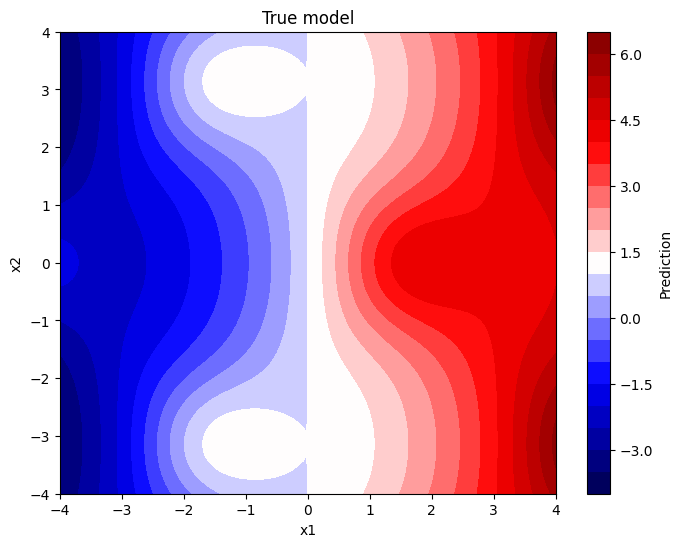

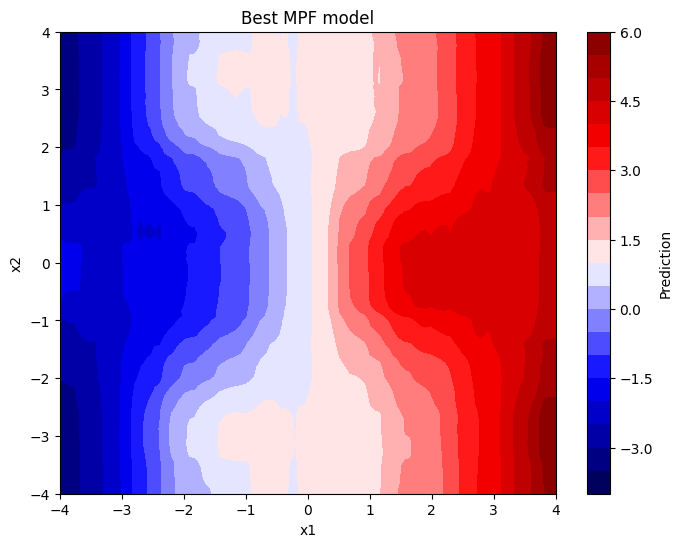

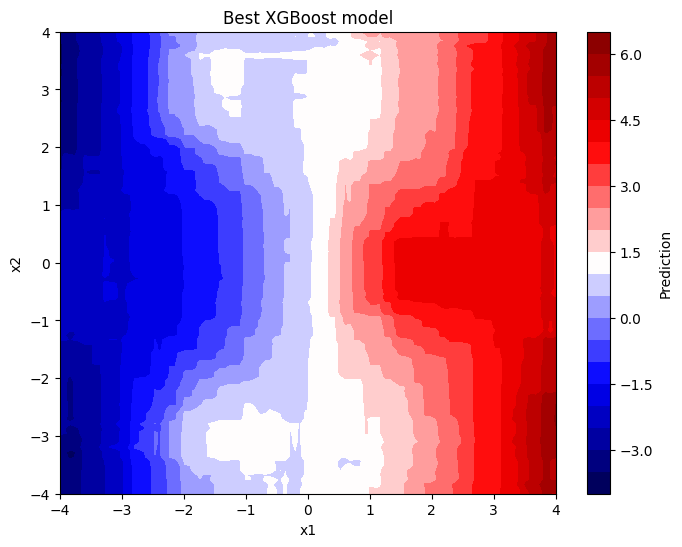

In [9]:
# Assuming plot_model_predictions is defined in your environment
plot_2d_model_predictions(true_model3, title="True model")
plot_2d_model_predictions(lambda x: best_model.predict(x), title="Best MPF model")
plot_2d_model_predictions(lambda x: best_model_xgboost.predict(x), title="Best XGBoost model")


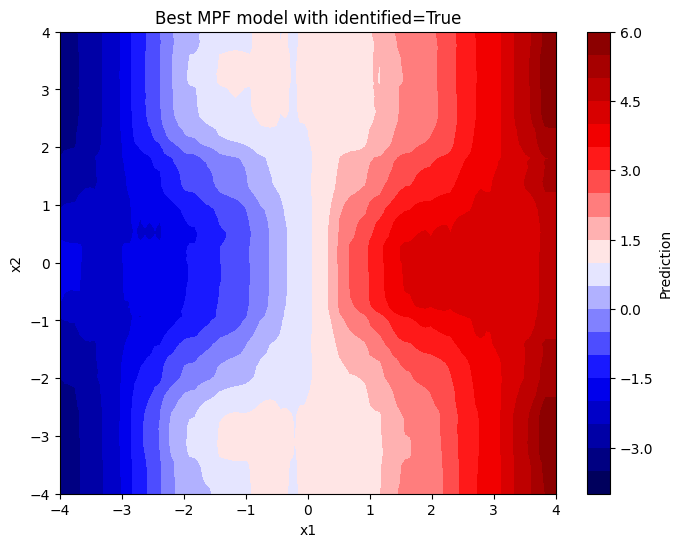

Test MSE for MPF with identified=True: 0.26414031802588317


In [10]:
# Plot the best MPF model with identified=True
plot_2d_model_predictions(lambda x: best_model.predict(x), title="Best MPF model with identified=True")
test_preds = best_model.predict(x_test)
test_error = np.mean((y_test - test_preds) ** 2)
print(f"Test MSE for MPF with identified=True: {test_error}")


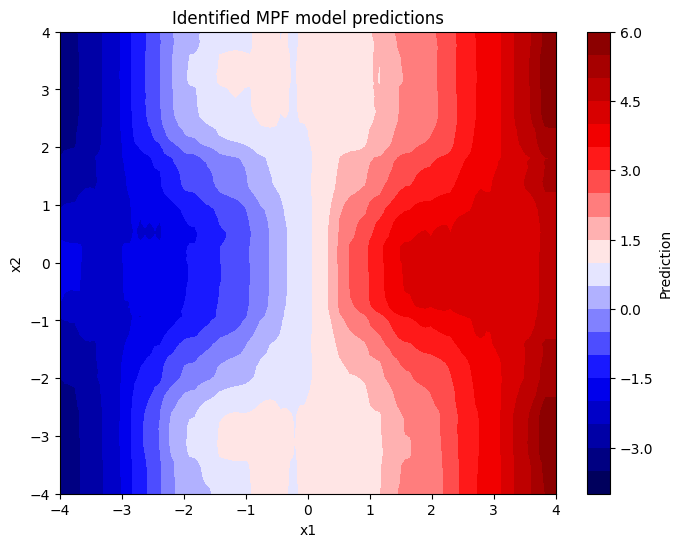

Test MSE for MPF with identified=True: 0.26414031802588317


In [11]:
mpf_tree_grid_rep = [mpf_py.TreeGrid(tgf.combined_tree_grid) for tgf in best_model.tree_grid_families]

pred_function = lambda x: sum([tg.predict(x) for tg in mpf_tree_grid_rep])

plot_2d_model_predictions(pred_function, title="Identified MPF model predictions")
test_preds_identified = pred_function(x_test)
test_error_identified = np.mean((y_test - test_preds_identified) ** 2)
print(f"Test MSE for MPF with identified=True: {test_error_identified}")


/Users/sqf320/Documents/rust-projects/rpf-rust/mpf-py/python/mpf_py/mpf.py:80: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


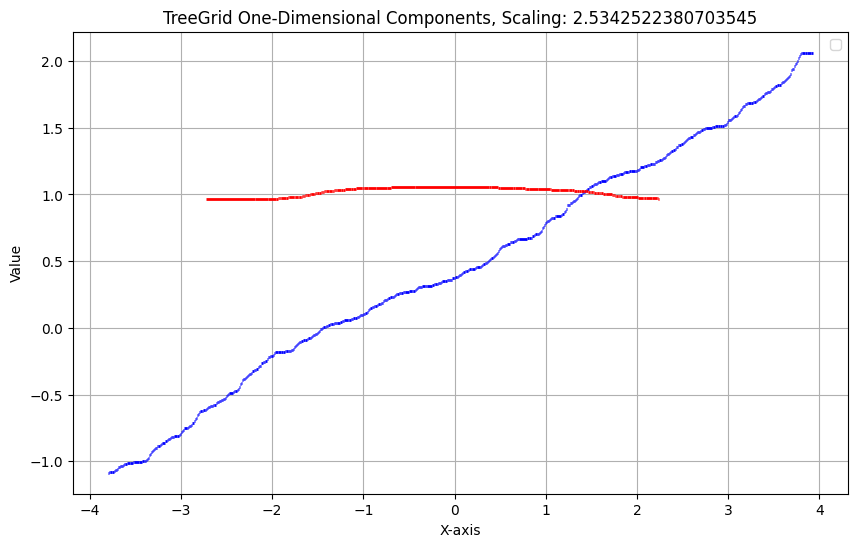

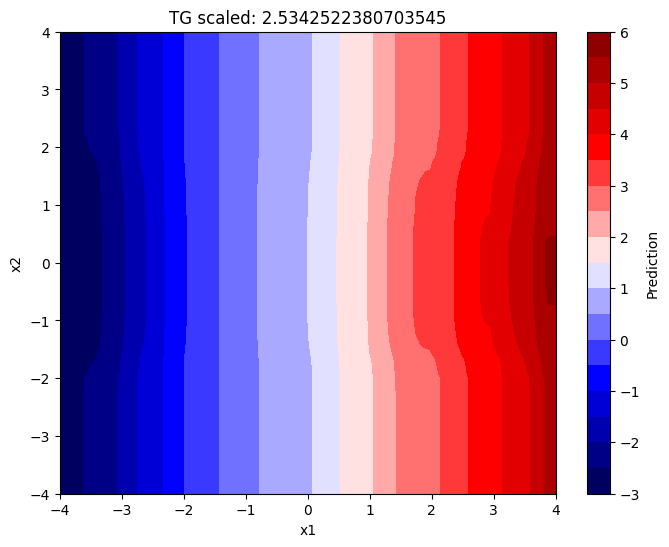

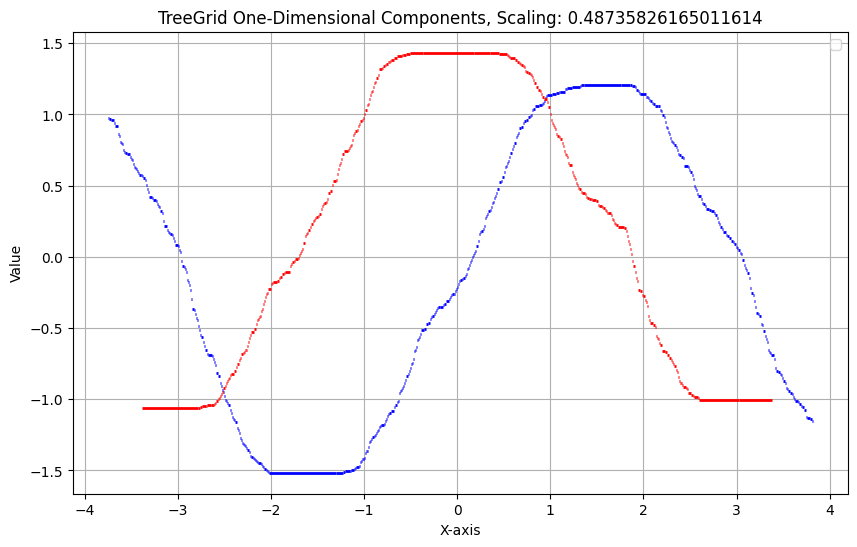

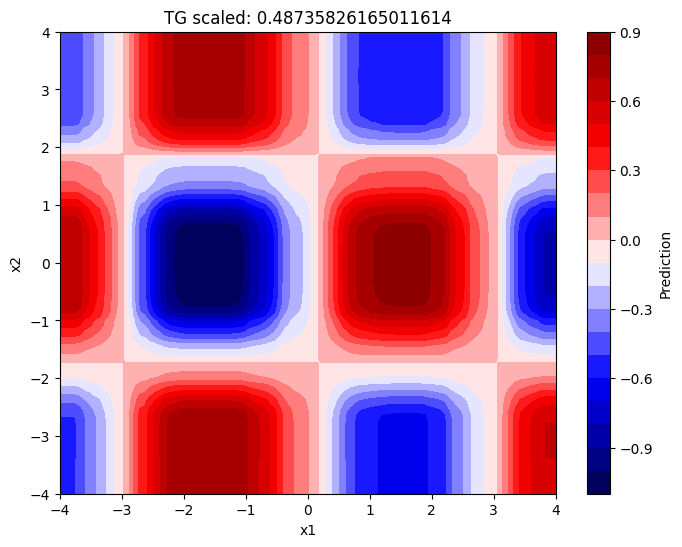

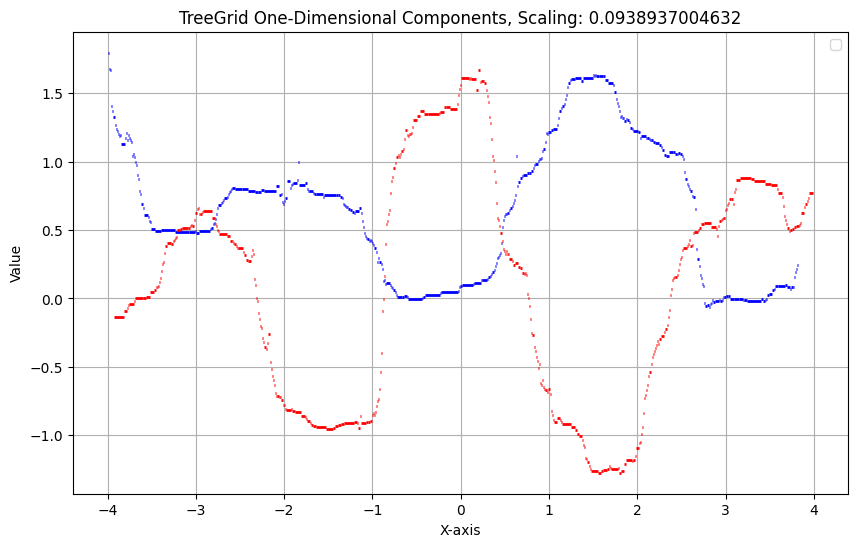

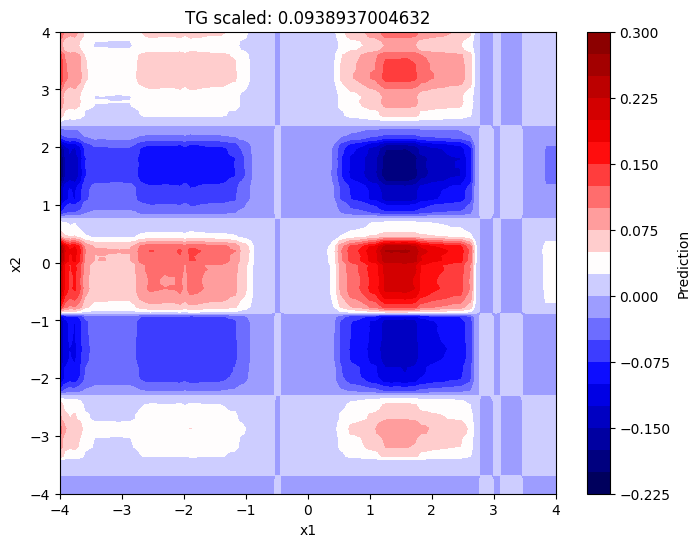

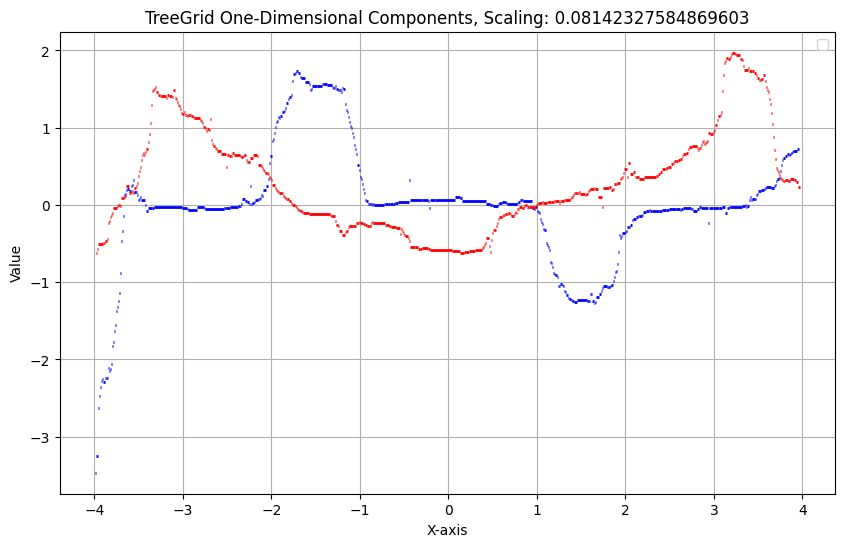

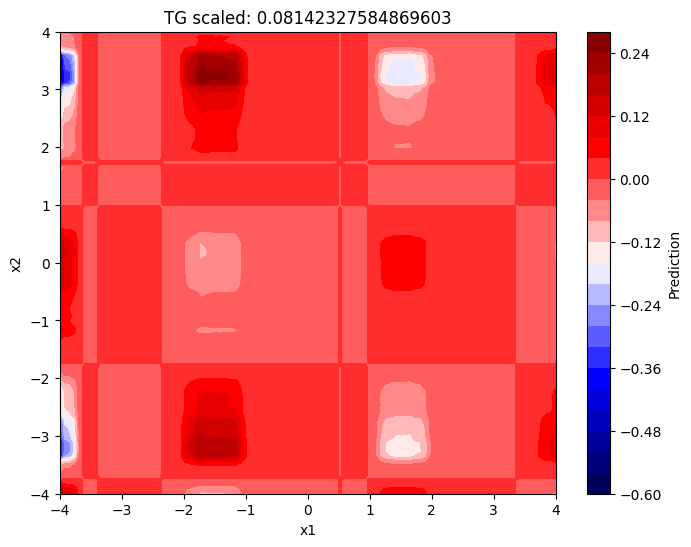

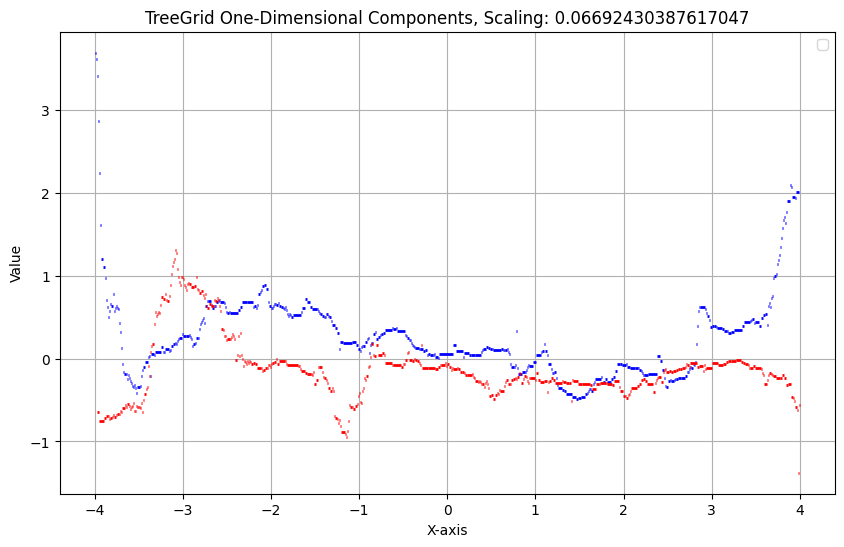

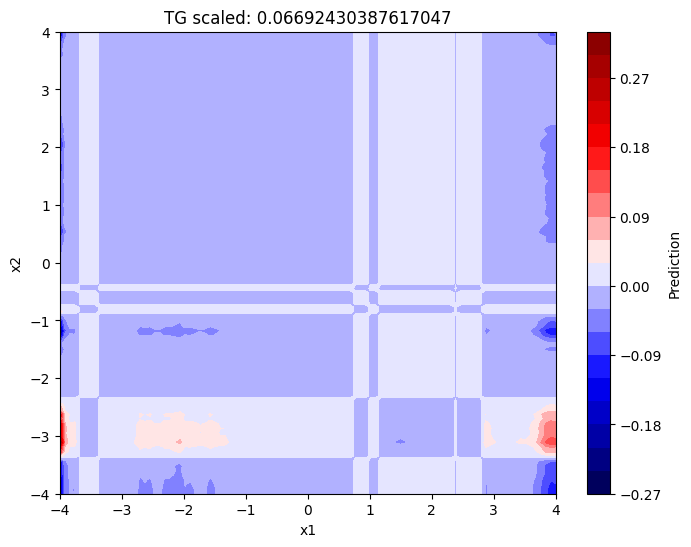

In [12]:
for tg in mpf_tree_grid_rep:
    tg.plot_components()
    plot_2d_model_predictions(lambda x: tg.predict(x), title=f"TG scaled: {tg.scaling}")
